In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import pickle

In [4]:
with open('../saved_samples/mnist_weights/trajectories/sgld/100_samples_seed-1.pkl', 'rb') as fp:
    samples = pickle.load(fp)
    
    

In [5]:
samples[0][1]

([OrderedDict([('linear.weight',
                tensor([[ 0.2491,  0.0401, -0.2135,  ...,  0.2880,  0.0333,  0.0653],
                        [-0.0709,  0.0609, -0.1806,  ...,  0.0842,  0.2587, -0.0576]])),
               ('linear.bias', tensor([0.0472, 0.0550]))]),
  OrderedDict([('linear.weight',
                tensor([[ 0.2735,  0.0685, -0.2389,  ...,  0.2911,  0.0213,  0.0434],
                        [-0.0474,  0.0622, -0.1649,  ...,  0.0799,  0.2444, -0.0296]])),
               ('linear.bias', tensor([0.0306, 0.0596]))]),
  OrderedDict([('linear.weight',
                tensor([[ 0.2591,  0.0714, -0.2410,  ...,  0.2980,  0.0380,  0.0435],
                        [-0.0327,  0.0252, -0.1572,  ...,  0.0789,  0.2246, -0.0170]])),
               ('linear.bias', tensor([0.0311, 0.0549]))]),
  OrderedDict([('linear.weight',
                tensor([[ 0.2992,  0.0885, -0.1717,  ...,  0.3131,  0.0789,  0.0450],
                        [-0.0087,  0.0277, -0.1651,  ...,  0.0701,  0.2293,  

In [25]:
with open('../data/psy_weights_const_full_no_reg2.pckl', 'rb') as fp:
    psy_weights = pickle.load(fp)

In [5]:
with open('../data/psy_weights2.pckl', 'rb') as fp:
    psy_weights2 = pickle.load(fp)

In [7]:
from control_variates.uncertainty_quantification import ClassificationUncertaintyMCMC

In [10]:
from mnist_utils import load_mnist_dataset
train_dl, valid_dl = load_mnist_dataset('../data/mnist/', 20000, [3, 5])

In [11]:
x_new, y_new = next(iter(valid_dl))
train_x, train_y = next(iter(train_dl))

In [12]:
samples = samples[0]

In [13]:
from control_variates.model import LogRegression

In [14]:
trajectories = [[LogRegression(784)
                 for j in range(len(samples[i][0]))]
                for i in range(len(samples))]

for i in range(len(samples)):
    for j in range(len(samples[i][0])):
        trajectories[i][j].load_state_dict(samples[i][0][j])

priors = [samples[i][1] for i in range(len(samples))]

In [26]:
from control_variates.cv import PsyLinear, SteinCV, PsyConstVector
from control_variates.cv_utils import state_dict_to_vec, compute_naive_variance
from control_variates.model import get_binary_prediction
import numpy as np

In [27]:
psy_models = [PsyConstVector(1570) for _ in range(len(psy_weights))]
for i in range(len(psy_weights)):
    psy_models[i].load_state_dict(psy_weights[i])

In [28]:
ncv_s = [SteinCV(psy_model, train_x, train_y, prior, len(train_dl.dataset)) for psy_model, prior in zip(psy_models, priors)]

In [29]:
len(ncv_s)

100

In [30]:
from tqdm import tqdm

In [31]:
predictions = []
predictions2 = []
mean_cvs = []
x = x_new[[9]]
for models, ncv in tqdm(zip(trajectories, ncv_s)):
    uq = ClassificationUncertaintyMCMC(models, ncv)
    mean_cvs.append(uq.control_variate(models, x).mean().item())
    predictions.append(uq.estimate_emperical_mean(x, use_cv=True).item())
    predictions2.append(uq.estimate_emperical_mean(x, use_cv=False).mean().item())

100it [00:16,  6.76it/s]


In [21]:
uq.estimate_emperical_mean(x, use_cv=False).shape

torch.Size([1])

In [22]:
plt.imshow(x[0][0])

NameError: name 'plt' is not defined

In [88]:
mean_cvs

[0.6906493306159973,
 0.459884911775589,
 0.39609378576278687,
 -0.1447853296995163,
 -0.3335528075695038,
 0.18213093280792236,
 -0.7453045845031738,
 0.2827748656272888,
 0.28250572085380554,
 -0.5708611607551575,
 0.32243725657463074,
 0.7448655962944031,
 0.6369494795799255,
 -1.8737280368804932,
 -0.614073634147644,
 0.6373286843299866,
 0.58467698097229,
 -0.5445688366889954,
 -0.6092315316200256,
 -0.4465777277946472,
 -0.13280826807022095,
 -0.029537806287407875,
 -0.5689752101898193,
 0.017723767086863518,
 0.6478661894798279,
 0.19825294613838196,
 -0.35472559928894043,
 0.4338468909263611,
 -0.5810813903808594,
 0.8199688196182251,
 -0.28852859139442444,
 -0.2093663364648819,
 -0.2412334829568863,
 0.2550760805606842,
 0.8445916175842285,
 0.5437285304069519,
 -0.6596545577049255,
 0.6915808320045471,
 -0.4321728050708771,
 -0.6717803478240967,
 -0.02066938392817974,
 0.3328012526035309,
 -0.22241906821727753,
 -0.18915419280529022,
 -0.3216516971588135,
 0.694264829158783,


In [36]:
import torch
predictions = torch.stack([model(x) for model in models])
ncv_v = ncv(models, x)

In [42]:
!pip install seaborn
import seaborn as sns

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6d540e1c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6d540f1320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6d540e1940>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6d540f19b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6d540f1cf8>,
 'means': []}

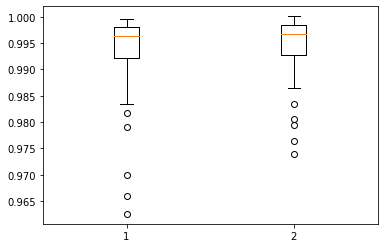

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
fig7, ax7 = plt.subplots()
#ax7.boxplot(predictions)
ax7.boxplot([predictions2, predictions, ])

In [24]:
uq.control_variate(models, x_new[[27]])

tensor([[-0.0093],
        [-0.0277],
        [-0.0109],
        [ 0.0111],
        [-0.0586],
        [-0.0046],
        [-0.0200],
        [ 0.0225],
        [ 0.0112],
        [ 0.0134],
        [-0.0422],
        [ 0.0201],
        [ 0.0097],
        [-0.0162],
        [-0.0135],
        [ 0.0134],
        [-0.0079],
        [ 0.0115],
        [ 0.0015],
        [ 0.0079],
        [ 0.0147],
        [ 0.0010],
        [ 0.0231],
        [ 0.0108],
        [ 0.0031],
        [-0.0087],
        [ 0.0041],
        [ 0.0280],
        [-0.0212],
        [ 0.0210],
        [ 0.0015],
        [-0.0059],
        [-0.0015],
        [ 0.0255],
        [-0.0085],
        [ 0.0118],
        [-0.0080],
        [ 0.0094],
        [ 0.0103],
        [-0.0093],
        [ 0.0092],
        [ 0.0034],
        [-0.0385],
        [-0.0038],
        [-0.0022],
        [ 0.0116],
        [-0.0107],
        [-0.0156],
        [ 0.0091],
        [-0.0090]], grad_fn=<AddBackward0>)

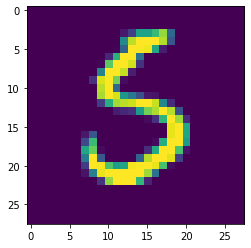

In [74]:
plt.imshow(x_new[27][0])